# RNN with Sentimental Analysis

In [1]:
import requests
import bs4
import urllib
import webbrowser
import re
import csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
from matplotlib import pyplot as plt
import datetime
from datetime import date
import time
import seaborn as sns
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pycorenlp import StanfordCoreNLP
nltk.download('vader_lexicon')
sia=SIA()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [49]:
df_sa = pd.read_csv('GoogleSentiments.csv',index_col=[0])

In [50]:
df = pd.read_csv("Google.csv",index_col = 0)
datetime.datetime.strptime(df['Date'][0],'%b %d, %Y')
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%b %d, %Y')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df['low'] = df['low'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['adj_close**'] = df['adj_close**'].astype(float)
df.drop(['close*'],axis = 1,inplace = True)
df.drop(['volume'],axis = 1, inplace = True)

In [51]:
final_scores = df_sa.iloc[:,0].values
df_rnn = df
df_rnn= df_rnn[:-2]

In [52]:
len(final_scores)

166

In [53]:
df_rnn['sentiments'] = final_scores

<ipython-input-53-23907019d286>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn['sentiments'] = final_scores


In [11]:
df_rnn

date     open     high      low  adj_close**  sentiments
0   2019-05-31  1105.64  1113.40  1103.35      1106.50    0.500000
1   2019-06-03  1066.93  1067.00  1027.03      1038.74    2.000000
2   2019-06-04  1044.49  1058.44  1036.03      1054.49    0.000000
3   2019-06-05  1055.00  1056.81  1033.00      1044.64    2.000000
4   2019-06-06  1046.21  1050.00  1035.51      1047.76    3.000000
..         ...      ...      ...      ...          ...         ...
161 2020-01-22  1007.25  1011.95   990.25       992.49    1.000000
162 2020-01-23   990.00  1011.05   990.00       992.29    1.000000
163 2020-01-24   995.15  1009.90   991.55       992.49    2.333333
164 2020-01-27   985.00  1005.00   985.00       986.57    1.000000
165 2020-01-28   985.00  1005.95   981.00       983.28    1.000000

[166 rows x 6 columns]

In [54]:
scaler = StandardScaler()
df_rnn = df_rnn.loc[:, ['open','high','low','adj_close**','sentiments']]
df_rnn = scaler.fit_transform(df_rnn)
df_rnn = np.array(df_rnn)

In [13]:
df_rnn

array([[ 1.32189719e-01,  8.46214515e-02,  2.15651448e-01,
         1.57233588e-01, -1.28169894e+00],
       [-2.55399430e-01, -3.91999196e-01, -5.36756617e-01,
        -5.02702289e-01,  1.19387729e+00],
       [-4.80082987e-01, -4.79927488e-01, -4.48029251e-01,
        -3.49308103e-01, -2.10689102e+00],
       [-3.74850181e-01, -4.96670842e-01, -4.77900797e-01,
        -4.45240340e-01,  1.19387729e+00],
       [-4.62861253e-01, -5.66623140e-01, -4.53155721e-01,
        -4.14853682e-01,  2.84426145e+00],
       [-3.82059279e-01, -3.25950257e-01, -2.98967276e-01,
        -2.14126433e-01,  1.19387729e+00],
       [-1.54572183e-01, -1.06026807e-01, -6.10793487e-02,
        -7.39777126e-02, -4.56506862e-01],
       [ 4.55804154e-02, -1.18325977e-02, -1.87859708e-02,
        -9.07293317e-02, -4.56506862e-01],
       [-1.25034906e-01, -2.32577807e-01, -1.17076175e-01,
        -1.09623600e-01, -4.56506862e-01],
       [-7.73747577e-02, -8.80508132e-02,  1.07898179e-02,
         6.37162312e-03

In [55]:
def get_x_y(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i,1])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [56]:
X, y = get_x_y(df_rnn, 7, 7)

In [57]:
X.shape

(159, 7, 5)

In [58]:
X_train = []
for i in range(124):
    X_train.append(X[i])
y_train = y[:124]

X_test = []
for i in range(124, len(X)):
    X_test.append(X[i])

y_test = y[124:]

In [59]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [60]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],5)))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(Dense(1))

In [61]:
model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2)

Epoch 1/50
 - 4s - loss: 0.3105
Epoch 2/50
 - 1s - loss: 0.2826
Epoch 3/50
 - 1s - loss: 0.2946
Epoch 4/50
 - 1s - loss: 0.2849
Epoch 5/50
 - 1s - loss: 0.2378
Epoch 6/50
 - 1s - loss: 0.2386
Epoch 7/50
 - 1s - loss: 0.2340
Epoch 8/50
 - 1s - loss: 0.1977
Epoch 9/50
 - 1s - loss: 0.2425
Epoch 10/50
 - 1s - loss: 0.2312
Epoch 11/50
 - 1s - loss: 0.2166
Epoch 12/50
 - 1s - loss: 0.1843
Epoch 13/50
 - 1s - loss: 0.1978
Epoch 14/50
 - 1s - loss: 0.1711
Epoch 15/50
 - 1s - loss: 0.1606
Epoch 16/50
 - 1s - loss: 0.2128
Epoch 17/50
 - 1s - loss: 0.1725
Epoch 18/50
 - 1s - loss: 0.1703
Epoch 19/50
 - 1s - loss: 0.1668
Epoch 20/50
 - 1s - loss: 0.1433
Epoch 21/50
 - 1s - loss: 0.1738
Epoch 22/50
 - 1s - loss: 0.1849
Epoch 23/50
 - 1s - loss: 0.1692
Epoch 24/50
 - 1s - loss: 0.1707
Epoch 25/50
 - 1s - loss: 0.1796
Epoch 26/50
 - 1s - loss: 0.1392
Epoch 27/50
 - 1s - loss: 0.1701
Epoch 28/50
 - 1s - loss: 0.1406
Epoch 29/50
 - 1s - loss: 0.1499
Epoch 30/50
 - 1s - loss: 0.1487
Epoch 31/50
 - 1s -

In [62]:
est = model.predict(X_test)


In [63]:
len(est)

35

In [64]:
est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[-35:]['date']})
test = pd.DataFrame(columns=['date','high'])
test['date'] = df['date'][-35:]
test['high'] = y_test

Text(0, 0.5, 'USD')

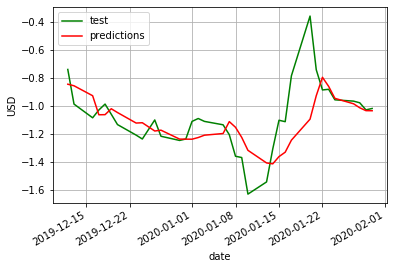

In [65]:
ax = test.plot(x='date', y='high', style='g-', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [66]:
from sklearn.metrics import mean_squared_error
error_LR = mean_squared_error(y_test,est)
print(error_LR)

0.03575625640750004


## Britannia with Nifty Sentiments

In [141]:
df_sa = pd.read_csv('Nifty50Sentiments.csv',index_col=[0])

In [142]:
df = pd.read_csv("Britannia.csv",index_col = 0)
datetime.datetime.strptime(df['Date'][0],'%b %d, %Y')
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%b %d, %Y')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df['low'] = df['low'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['adj_close**'] = df['adj_close**'].astype(float)
df.drop(['close*'],axis = 1,inplace = True)
df.drop(['volume'],axis = 1, inplace = True)

In [143]:
final_scores = df_sa.iloc[:,0].values
df_rnn = df
df_rnn= df_rnn[:-2]

In [75]:
df_rnn

date     open     high      low  adj_close**
0   2019-06-03  2936.00  3000.00  2935.90      2953.10
1   2019-06-04  2970.20  2985.00  2951.00      2946.04
2   2019-06-06  2965.30  2977.95  2881.80      2884.64
3   2019-06-07  2905.00  2919.30  2860.00      2882.61
4   2019-06-10  2909.70  3005.00  2909.70      2977.06
..         ...      ...      ...      ...          ...
157 2020-01-23  3103.85  3122.90  3068.10      3112.95
158 2020-01-24  3113.15  3212.95  3112.05      3192.50
159 2020-01-27  3187.00  3210.00  3155.00      3174.20
160 2020-01-28  3182.90  3209.90  3136.50      3181.25
161 2020-01-29  3200.00  3245.50  3190.05      3214.20

[162 rows x 5 columns]

In [72]:
len(final_scores)

162

In [144]:
df_rnn['sentiments'] = final_scores

<ipython-input-144-23907019d286>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn['sentiments'] = final_scores


In [77]:
df_rnn

date     open     high      low  adj_close**  sentiments
0   2019-06-03  2936.00  3000.00  2935.90      2953.10    1.250000
1   2019-06-04  2970.20  2985.00  2951.00      2946.04    1.000000
2   2019-06-06  2965.30  2977.95  2881.80      2884.64    1.333333
3   2019-06-07  2905.00  2919.30  2860.00      2882.61    1.000000
4   2019-06-10  2909.70  3005.00  2909.70      2977.06    1.250000
..         ...      ...      ...      ...          ...         ...
157 2020-01-23  3103.85  3122.90  3068.10      3112.95    1.250000
158 2020-01-24  3113.15  3212.95  3112.05      3192.50    1.000000
159 2020-01-27  3187.00  3210.00  3155.00      3174.20    1.000000
160 2020-01-28  3182.90  3209.90  3136.50      3181.25    1.333333
161 2020-01-29  3200.00  3245.50  3190.05      3214.20    1.000000

[162 rows x 6 columns]

In [145]:
scaler = StandardScaler()
df_rnn = df_rnn.loc[:, ['open','high','low','adj_close**','sentiments']]
df_rnn = scaler.fit_transform(df_rnn)
df_rnn = np.array(df_rnn)

In [146]:
def get_x_y(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i,1])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [147]:
X, y = get_x_y(df_rnn, 7, 7)

In [148]:
X_train = []
for i in range(124):
    X_train.append(X[i])
y_train = y[:124]

X_test = []
for i in range(124, len(X)):
    X_test.append(X[i])

y_test = y[124:]
X_train = np.array(X_train)
X_test = np.array(X_test)

In [149]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],5)))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(Dense(1))

In [150]:
model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2)

Epoch 1/50
 - 3s - loss: 0.4505
Epoch 2/50
 - 0s - loss: 0.3690
Epoch 3/50
 - 0s - loss: 0.3000
Epoch 4/50
 - 0s - loss: 0.2974
Epoch 5/50
 - 1s - loss: 0.3067
Epoch 6/50
 - 1s - loss: 0.2856
Epoch 7/50
 - 0s - loss: 0.2297
Epoch 8/50
 - 0s - loss: 0.2575
Epoch 9/50
 - 0s - loss: 0.2388
Epoch 10/50
 - 0s - loss: 0.2623
Epoch 11/50
 - 0s - loss: 0.2548
Epoch 12/50
 - 0s - loss: 0.2125
Epoch 13/50
 - 0s - loss: 0.2356
Epoch 14/50
 - 0s - loss: 0.2374
Epoch 15/50
 - 0s - loss: 0.2077
Epoch 16/50
 - 0s - loss: 0.2117
Epoch 17/50
 - 0s - loss: 0.2146
Epoch 18/50
 - 0s - loss: 0.2345
Epoch 19/50
 - 0s - loss: 0.2010
Epoch 20/50
 - 0s - loss: 0.1938
Epoch 21/50
 - 1s - loss: 0.2105
Epoch 22/50
 - 1s - loss: 0.2185
Epoch 23/50
 - 0s - loss: 0.1778
Epoch 24/50
 - 0s - loss: 0.1868
Epoch 25/50
 - 0s - loss: 0.1949
Epoch 26/50
 - 0s - loss: 0.1890
Epoch 27/50
 - 0s - loss: 0.2060
Epoch 28/50
 - 0s - loss: 0.1895
Epoch 29/50
 - 0s - loss: 0.1919
Epoch 30/50
 - 0s - loss: 0.1784
Epoch 31/50
 - 0s -

In [151]:
est = model.predict(X_test)

In [152]:
len(est)

31

Text(0, 0.5, 'USD')

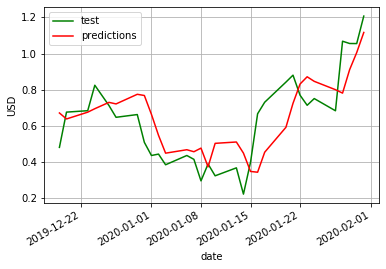

In [153]:
est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[-31:]['date']})
test = pd.DataFrame(columns=['date','high'])
test['date'] = df['date'][-31:]
test['high'] = y_test
ax = test.plot(x='date', y='high', style='g-', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [154]:
from sklearn.metrics import mean_squared_error
error_LR = mean_squared_error(y_test,est)
print(error_LR)

0.025320481969467085


## Britannia

In [89]:
df_sa = pd.read_csv('BritanniaSentiments.csv',index_col=[0])
df = pd.read_csv("Britannia.csv",index_col = 0)
datetime.datetime.strptime(df['Date'][0],'%b %d, %Y')
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%b %d, %Y')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df['low'] = df['low'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['adj_close**'] = df['adj_close**'].astype(float)
df.drop(['close*'],axis = 1,inplace = True)
df.drop(['volume'],axis = 1, inplace = True)

In [90]:
final_scores = df_sa.iloc[:,0].values
df_rnn = df

In [91]:
df_rnn

date     open     high      low  adj_close**
0   2019-06-03  2936.00  3000.00  2935.90      2953.10
1   2019-06-04  2970.20  2985.00  2951.00      2946.04
2   2019-06-06  2965.30  2977.95  2881.80      2884.64
3   2019-06-07  2905.00  2919.30  2860.00      2882.61
4   2019-06-10  2909.70  3005.00  2909.70      2977.06
..         ...      ...      ...      ...          ...
159 2020-01-27  3187.00  3210.00  3155.00      3174.20
160 2020-01-28  3182.90  3209.90  3136.50      3181.25
161 2020-01-29  3200.00  3245.50  3190.05      3214.20
162 2020-01-30  3208.95  3234.70  3192.45      3210.70
163 2020-01-31  3242.70  3274.60  3186.85      3200.70

[164 rows x 5 columns]

In [92]:
len(final_scores)

164

In [93]:
df_rnn['sentiments'] = final_scores

In [94]:
scaler = StandardScaler()
df_rnn = df_rnn.loc[:, ['open','high','low','adj_close**','sentiments']]
df_rnn = scaler.fit_transform(df_rnn)
df_rnn = np.array(df_rnn)

In [95]:
def get_x_y(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i,1])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [96]:
X, y = get_x_y(df_rnn, 7, 7)

In [97]:
X_train = []
for i in range(124):
    X_train.append(X[i])
y_train = y[:124]

X_test = []
for i in range(124, len(X)):
    X_test.append(X[i])

y_test = y[124:]
X_train = np.array(X_train)
X_test = np.array(X_test)

In [98]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],5)))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(Dense(1))

In [99]:
model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2)

Epoch 1/50
 - 2s - loss: 0.4581
Epoch 2/50
 - 0s - loss: 0.3214
Epoch 3/50
 - 0s - loss: 0.2996
Epoch 4/50
 - 0s - loss: 0.3003
Epoch 5/50
 - 0s - loss: 0.2945
Epoch 6/50
 - 0s - loss: 0.2591
Epoch 7/50
 - 0s - loss: 0.2430
Epoch 8/50
 - 0s - loss: 0.2486
Epoch 9/50
 - 0s - loss: 0.2383
Epoch 10/50
 - 0s - loss: 0.2116
Epoch 11/50
 - 0s - loss: 0.2309
Epoch 12/50
 - 0s - loss: 0.2213
Epoch 13/50
 - 0s - loss: 0.2182
Epoch 14/50
 - 0s - loss: 0.2532
Epoch 15/50
 - 0s - loss: 0.2257
Epoch 16/50
 - 0s - loss: 0.1995
Epoch 17/50
 - 0s - loss: 0.2127
Epoch 18/50
 - 0s - loss: 0.1853
Epoch 19/50
 - 0s - loss: 0.1879
Epoch 20/50
 - 0s - loss: 0.2019
Epoch 21/50
 - 0s - loss: 0.1965
Epoch 22/50
 - 0s - loss: 0.1921
Epoch 23/50
 - 0s - loss: 0.1608
Epoch 24/50
 - 0s - loss: 0.1935
Epoch 25/50
 - 0s - loss: 0.1903
Epoch 26/50
 - 0s - loss: 0.2115
Epoch 27/50
 - 0s - loss: 0.1961
Epoch 28/50
 - 0s - loss: 0.1936
Epoch 29/50
 - 1s - loss: 0.1693
Epoch 30/50
 - 1s - loss: 0.1857
Epoch 31/50
 - 0s -

In [100]:
est = model.predict(X_test)

In [101]:
len(est)

33

Text(0, 0.5, 'USD')

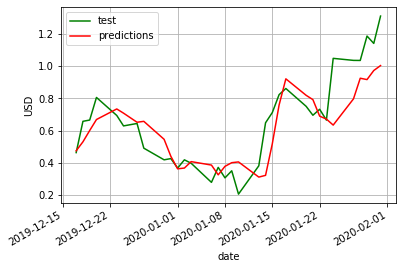

In [102]:
est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[-33:]['date']})
test = pd.DataFrame(columns=['date','high'])
test['date'] = df['date'][-33:]
test['high'] = y_test
ax = test.plot(x='date', y='high', style='g-', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [103]:
from sklearn.metrics import mean_squared_error
error_LR = mean_squared_error(y_test,est)
print(error_LR)

0.023250570980299104


## Infosys

In [104]:
df_sa = pd.read_csv('InfosysSentiments.csv',index_col=[0])
df = pd.read_csv("Infosys.csv",index_col = 0)
datetime.datetime.strptime(df['Date'][0],'%b %d, %Y')
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%b %d, %Y')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df['low'] = df['low'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['adj_close**'] = df['adj_close**'].astype(float)
df.drop(['close*'],axis = 1,inplace = True)
df.drop(['volume'],axis = 1, inplace = True)

In [105]:
final_scores = df_sa.iloc[:,0].values
df_rnn = df

In [106]:
df_rnn

date    open    high     low  adj_close**
0   2019-06-03  729.80  750.90  729.00       717.59
1   2019-06-04  737.25  739.45  733.15       708.58
2   2019-06-06  736.50  744.65  733.65       708.87
3   2019-06-07  735.85  743.95  735.85       712.25
4   2019-06-10  740.10  754.10  740.10       726.12
..         ...     ...     ...     ...          ...
159 2020-01-27  779.05  784.80  774.40       778.10
160 2020-01-28  781.00  781.80  772.00       778.00
161 2020-01-29  786.60  792.80  784.25       789.70
162 2020-01-30  789.70  789.70  778.00       780.70
163 2020-01-31  780.55  784.95  771.60       775.95

[164 rows x 5 columns]

In [107]:
len(final_scores)

164

In [108]:
df_rnn['sentiments'] = final_scores

In [109]:
scaler = StandardScaler()
df_rnn = df_rnn.loc[:, ['open','high','low','adj_close**','sentiments']]
df_rnn = scaler.fit_transform(df_rnn)
df_rnn = np.array(df_rnn)

In [110]:
def get_x_y(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i,1])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [111]:
X, y = get_x_y(df_rnn, 7, 7)

In [112]:
X_train = []
for i in range(124):
    X_train.append(X[i])
y_train = y[:124]

X_test = []
for i in range(124, len(X)):
    X_test.append(X[i])

y_test = y[124:]
X_train = np.array(X_train)
X_test = np.array(X_test)

In [113]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],5)))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(Dense(1))

In [119]:
model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2)

Epoch 1/50
 - 3s - loss: 0.1072
Epoch 2/50
 - 1s - loss: 0.0942
Epoch 3/50
 - 1s - loss: 0.1016
Epoch 4/50
 - 1s - loss: 0.1115
Epoch 5/50
 - 1s - loss: 0.1080
Epoch 6/50
 - 1s - loss: 0.1172
Epoch 7/50
 - 0s - loss: 0.1067
Epoch 8/50
 - 1s - loss: 0.1060
Epoch 9/50
 - 0s - loss: 0.0868
Epoch 10/50
 - 0s - loss: 0.1117
Epoch 11/50
 - 0s - loss: 0.0932
Epoch 12/50
 - 0s - loss: 0.0974
Epoch 13/50
 - 0s - loss: 0.1025
Epoch 14/50
 - 0s - loss: 0.1100
Epoch 15/50
 - 1s - loss: 0.0881
Epoch 16/50
 - 1s - loss: 0.0872
Epoch 17/50
 - 1s - loss: 0.1065
Epoch 18/50
 - 0s - loss: 0.0924
Epoch 19/50
 - 0s - loss: 0.0994
Epoch 20/50
 - 0s - loss: 0.1141
Epoch 21/50
 - 0s - loss: 0.0863
Epoch 22/50
 - 0s - loss: 0.1017
Epoch 23/50
 - 0s - loss: 0.0949
Epoch 24/50
 - 0s - loss: 0.0915
Epoch 25/50
 - 0s - loss: 0.0930
Epoch 26/50
 - 0s - loss: 0.1020
Epoch 27/50
 - 0s - loss: 0.0866
Epoch 28/50
 - 0s - loss: 0.0746
Epoch 29/50
 - 0s - loss: 0.0903
Epoch 30/50
 - 1s - loss: 0.0950
Epoch 31/50
 - 1s -

In [120]:
est = model.predict(X_test)

In [121]:
len(est)

33

Text(0, 0.5, 'USD')

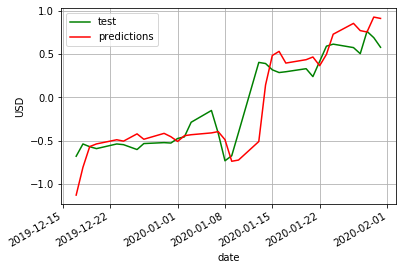

In [122]:
est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[-33:]['date']})
test = pd.DataFrame(columns=['date','high'])
test['date'] = df['date'][-33:]
test['high'] = y_test
ax = test.plot(x='date', y='high', style='g-', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [123]:
from sklearn.metrics import mean_squared_error
error_LR = mean_squared_error(y_test,est)
print(error_LR)

0.060351553985864385


## infosys with Nifty sentiments

In [124]:
df_sa = pd.read_csv('Nifty50Sentiments.csv',index_col=[0])
df = pd.read_csv("Infosys.csv",index_col = 0)
datetime.datetime.strptime(df['Date'][0],'%b %d, %Y')
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%b %d, %Y')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df['low'] = df['low'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['adj_close**'] = df['adj_close**'].astype(float)
df.drop(['close*'],axis = 1,inplace = True)
df.drop(['volume'],axis = 1, inplace = True)

In [128]:
final_scores = df_sa.iloc[:,0].values
df_rnn = df
df_rnn = df_rnn[:-2]

In [129]:
df_rnn

date    open    high     low  adj_close**
0   2019-06-03  729.80  750.90  729.00       717.59
1   2019-06-04  737.25  739.45  733.15       708.58
2   2019-06-06  736.50  744.65  733.65       708.87
3   2019-06-07  735.85  743.95  735.85       712.25
4   2019-06-10  740.10  754.10  740.10       726.12
..         ...     ...     ...     ...          ...
157 2020-01-23  777.10  785.50  776.70       784.35
158 2020-01-24  775.75  786.50  773.60       782.75
159 2020-01-27  779.05  784.80  774.40       778.10
160 2020-01-28  781.00  781.80  772.00       778.00
161 2020-01-29  786.60  792.80  784.25       789.70

[162 rows x 5 columns]

In [127]:
len(final_scores)

162

In [130]:
df_rnn['sentiments'] = final_scores

<ipython-input-130-23907019d286>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn['sentiments'] = final_scores


In [131]:
scaler = StandardScaler()
df_rnn = df_rnn.loc[:, ['open','high','low','adj_close**','sentiments']]
df_rnn = scaler.fit_transform(df_rnn)
df_rnn = np.array(df_rnn)

In [132]:
def get_x_y(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i,1])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [133]:
X, y = get_x_y(df_rnn, 7, 7)

In [134]:
X_train = []
for i in range(124):
    X_train.append(X[i])
y_train = y[:124]

X_test = []
for i in range(124, len(X)):
    X_test.append(X[i])

y_test = y[124:]
X_train = np.array(X_train)
X_test = np.array(X_test)

In [135]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],5)))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(Dense(1))

In [136]:
model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=2)

Epoch 1/50
 - 3s - loss: 0.4874
Epoch 2/50
 - 0s - loss: 0.3690
Epoch 3/50
 - 0s - loss: 0.3031
Epoch 4/50
 - 1s - loss: 0.2781
Epoch 5/50
 - 1s - loss: 0.2883
Epoch 6/50
 - 0s - loss: 0.2423
Epoch 7/50
 - 0s - loss: 0.2505
Epoch 8/50
 - 1s - loss: 0.2227
Epoch 9/50
 - 0s - loss: 0.1987
Epoch 10/50
 - 0s - loss: 0.1974
Epoch 11/50
 - 0s - loss: 0.1986
Epoch 12/50
 - 0s - loss: 0.2163
Epoch 13/50
 - 1s - loss: 0.1619
Epoch 14/50
 - 1s - loss: 0.1765
Epoch 15/50
 - 0s - loss: 0.1852
Epoch 16/50
 - 0s - loss: 0.1759
Epoch 17/50
 - 1s - loss: 0.1709
Epoch 18/50
 - 1s - loss: 0.1678
Epoch 19/50
 - 1s - loss: 0.1482
Epoch 20/50
 - 1s - loss: 0.1575
Epoch 21/50
 - 0s - loss: 0.1564
Epoch 22/50
 - 0s - loss: 0.1715
Epoch 23/50
 - 0s - loss: 0.1792
Epoch 24/50
 - 0s - loss: 0.1415
Epoch 25/50
 - 0s - loss: 0.1538
Epoch 26/50
 - 0s - loss: 0.1459
Epoch 27/50
 - 0s - loss: 0.1285
Epoch 28/50
 - 0s - loss: 0.1403
Epoch 29/50
 - 0s - loss: 0.1316
Epoch 30/50
 - 0s - loss: 0.1333
Epoch 31/50
 - 1s -

In [137]:
est = model.predict(X_test)

In [138]:
len(est)

31

Text(0, 0.5, 'USD')

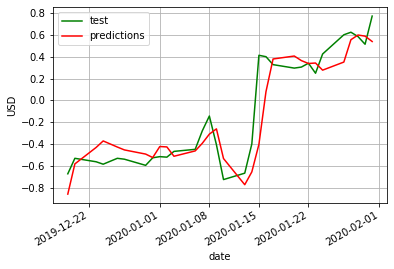

In [139]:
est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[-31:]['date']})
test = pd.DataFrame(columns=['date','high'])
test['date'] = df['date'][-31:]
test['high'] = y_test
ax = test.plot(x='date', y='high', style='g-', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [140]:
from sklearn.metrics import mean_squared_error
error_LR = mean_squared_error(y_test,est)
print(error_LR)

0.0406062033898496
